# Unusual Transactions Detection Using Isolation Forest. 

## **Heads-up**
The following programme is evaluated as a simple or a beginner-level project considering:
- ChatGPT generated dataset of ~5000 records: small and is already clean, making it easy for testing purposes. And this particular set of data might as well be impractical.
- Absolute no feature engineering.

Goal of this programme: Ready-to-go AI built-in System for .NET windows form project namely *Organizational Financial Application*.
Despite this being a rookie project, I'm surely getting it.

### 1. Importing libraries

In [13]:
import pyodbc
import joblib
import pandas as pd
from sklearn.ensemble import IsolationForest
import matplotlib.pyplot as plt

### 2. SQL Database connection string

In [2]:
connection = pyodbc.connect(
    r"DRIVER={ODBC Driver 17 for SQL Server};"
    r"SERVER=LAPTOP-SIASPIGN\SQLEXPRESS02;"
    r"DATABASE=OrgFinanceDB;"
    r"UID=sa;"
    r"PWD=sontung2004;"
)

### 3. SQL Querying and Data Preparation 

In [3]:
query = """
SELECT 
    T.TransactionID,
    F.FundName,
    F.FundType,
    C.CategoryName,
    C.CategoryType,
    P.PartnerName,
    P.PartnerType,
    T.TransactionDate,
    T.Amount,
    T.TransactionDescription
FROM Transactions T
JOIN Fund F ON T.FundID = F.FundID
JOIN Categories C ON T.CategoryID = C.CategoryID
LEFT JOIN BussinessPartner P ON T.PartnerID = P.PartnerID
"""

In [4]:
df = pd.read_sql(query, connection)
connection.close()

df.head()

C:\Users\admin\AppData\Local\Temp\ipykernel_6720\665202082.py:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, connection)


,TransactionID,FundName,FundType,CategoryName,CategoryType,PartnerName,PartnerType,TransactionDate,Amount,TransactionDescription
0,1,Cash on Hand,Cash,Utilities Expense,Expense,Thanh Cong Tax Agency,Supplier,2022-10-24,1863000.0,Utilities Expense payment
1,2,Cash on Hand,Cash,Service Revenue,Income,Sakura Ventures,Customer,2023-10-26,46099000.0,Service Revenue received
2,3,Savings Account,Bank,Salary Expense,Expense,Diep Chau Le,Staff,2024-12-25,56794000.0,Salary Expense payment
3,4,Cash on Hand,Cash,Office Supplies,Expense,Green Leaf Office Store,Supplier,2025-02-26,2799000.0,Office Supplies payment
4,5,Main Bank Account,Bank,Service Revenue,Income,GoGreen Solutions,Customer,2025-03-29,20426000.0,Service Revenue received


In [5]:
df['TransactionDate'] = pd.to_datetime(df['TransactionDate'])
df['Year'] = df['TransactionDate'].dt.year
df['Month'] = df['TransactionDate'].dt.month
df = df.sort_values(by=['Year', 'Month', 'TransactionDate'])
df = df.reset_index(drop=True)
df.head()

,TransactionID,FundName,FundType,CategoryName,CategoryType,PartnerName,PartnerType,TransactionDate,Amount,TransactionDescription,Year,Month
0,66,Main Bank Account,Bank,Product Sales,Income,VietBiz Technologies,Customer,2022-10-01,23635000.0,Product Sales received,2022,10
1,606,Petty Cash,Cash,Office Supplies,Expense,Bao Viet Insurance,Supplier,2022-10-01,2629000.0,Office Supplies payment,2022,10
2,909,Petty Cash,Cash,Office Supplies,Expense,Bao Viet Insurance,Supplier,2022-10-01,857000.0,Office Supplies payment,2022,10
3,1378,Cash on Hand,Cash,Utilities Expense,Expense,Bao Viet Insurance,Supplier,2022-10-01,2308000.0,Utilities Expense payment,2022,10
4,1727,Cash on Hand,Cash,Top-up fund,Income,Nam An Group,Customer,2022-10-01,3352000.0,Top-up fund received,2022,10


In [6]:
# Encode categorical columns
df['FundNameEncoded'] = df['FundName'].astype('category').cat.codes
df['FundTypeEncoded'] = df['FundType'].astype('category').cat.codes
df['CategoryNameEncoded'] = df['CategoryName'].astype('category').cat.codes
df['CategoryTypeEncoded'] = df['CategoryType'].astype('category').cat.codes
df['PartnerNameEncoded'] = df['PartnerName'].astype('category').cat.codes
df['PartnerTypeEncoded'] = df['PartnerType'].astype('category').cat.codes

In [7]:
features = df[[
    'Amount',
    'FundNameEncoded',
    'FundTypeEncoded',
    'CategoryNameEncoded',
    'CategoryTypeEncoded',
    'PartnerNameEncoded',
    'PartnerTypeEncoded'
]]

### 4. Fitting desired features into Isolation Forest

In [8]:
# Initialize and fit model
model = IsolationForest(n_estimators=100, contamination=0.05, random_state=42)
model.fit(features)

# Predict anomalies
df['anomaly_score'] = model.decision_function(features)
df['is_predicted_anomaly'] = model.predict(features) == -1  # True = anomaly

In [9]:
anomalies = df[df['is_predicted_anomaly']]
anomalies[['TransactionID', 'TransactionDate', 'Amount', 'CategoryName', 'FundName', 'PartnerName', 'anomaly_score']]

,TransactionID,TransactionDate,Amount,CategoryName,FundName,PartnerName,anomaly_score
35,2898,2022-10-06,66981000.0,Salary Expense,Savings Account,Lan Phuong Vo,-0.000594
45,3395,2022-10-07,39205000.0,Product Sales,Petty Cash,ABC Retail Co.,-0.008711
69,406,2022-10-13,57190000.0,Salary Expense,Main Bank Account,Tuan Anh Tran,-0.021491
74,2930,2022-10-13,47192000.0,Product Sales,Main Bank Account,VietBiz Technologies,-0.000117
84,405,2022-10-16,1219000.0,Investment Income,Savings Account,VietBiz Technologies,-0.001834
...,...,...,...,...,...,...,...
3794,1932,2025-02-26,67936000.0,Product Sales,Main Bank Account,ABC Retail Co.,-0.054540
3797,813,2025-02-27,500000.0,Salary Expense,Savings Account,Mai Lan Nguyen,-0.009666
3831,4107,2025-03-05,61584000.0,Product Sales,Savings Account,GoGreen Solutions,-0.013271
3861,3857,2025-03-11,942000.0,Investment Income,Cash on Hand,ABC Retail Co.,-0.004761


### 5. Results visualization

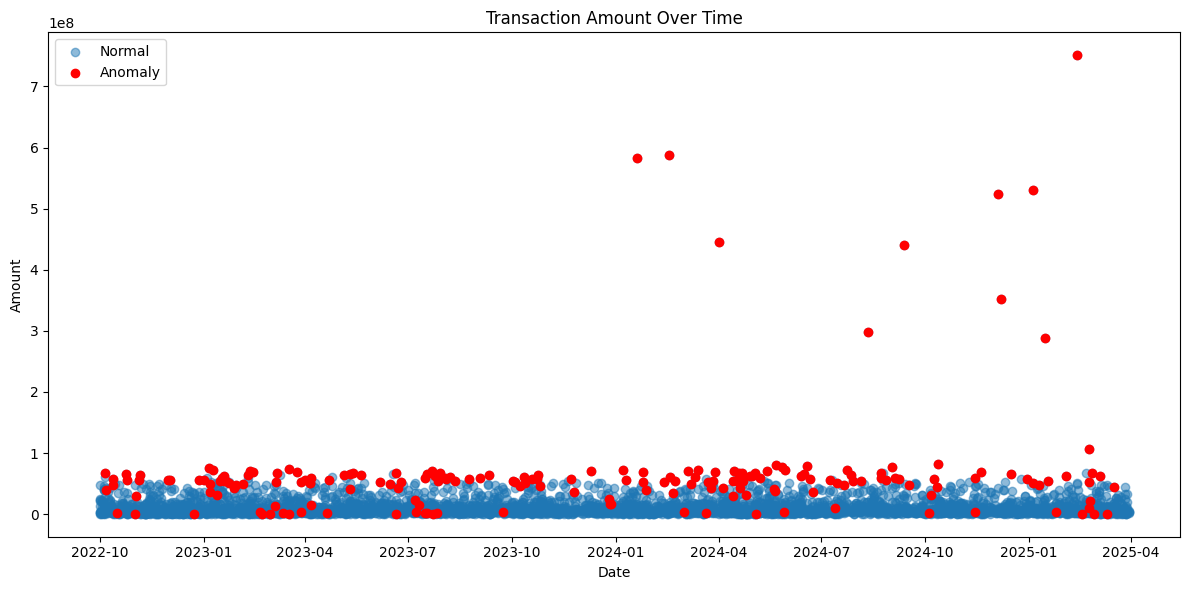

In [10]:
plt.figure(figsize=(12, 6))
plt.scatter(df['TransactionDate'], df['Amount'], label='Normal', alpha=0.5)
plt.scatter(anomalies['TransactionDate'], anomalies['Amount'], color='red', label='Anomaly')
plt.title('Transaction Amount Over Time')
plt.xlabel('Date')
plt.ylabel('Amount')
plt.legend()
plt.tight_layout()
plt.show()

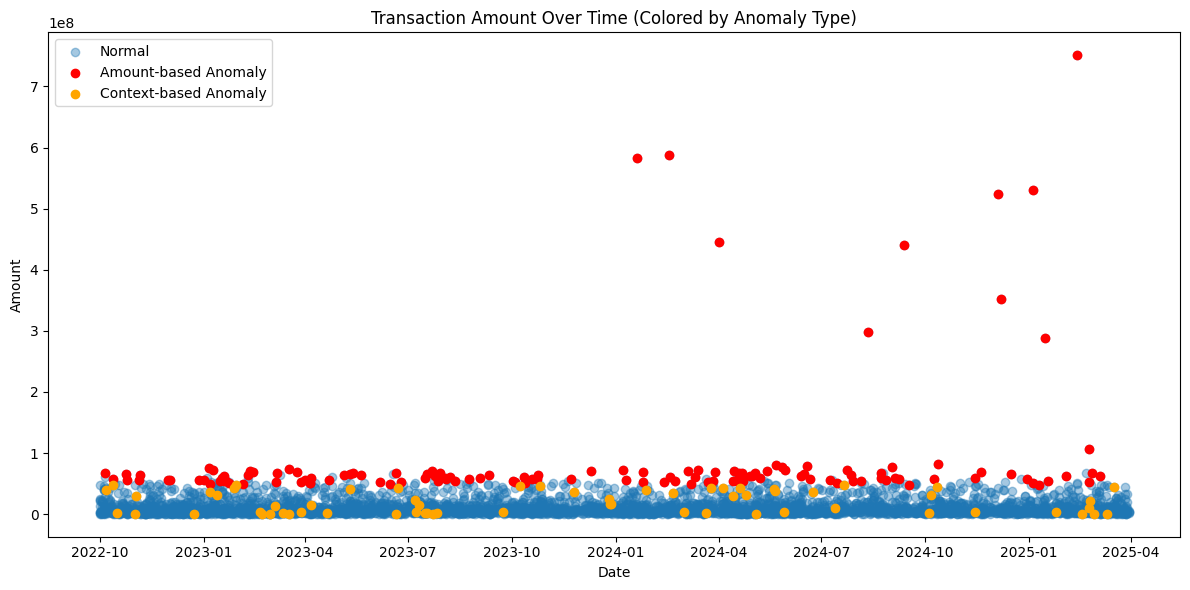

In [11]:
high_threshold = df['Amount'].quantile(0.95)
# Only apply to anomalies
anomalies = df[df['is_predicted_anomaly']].copy()

# Create a new column based on amount
anomalies['AnomalyType'] = anomalies['Amount'].apply(
    lambda x: 'amount-based' if x > high_threshold else 'context-based'
)

plt.figure(figsize=(12, 6))
plt.scatter(df['TransactionDate'], df['Amount'], label='Normal', alpha=0.4)

# Plot each type separately
plt.scatter(
    anomalies[anomalies['AnomalyType'] == 'amount-based']['TransactionDate'],
    anomalies[anomalies['AnomalyType'] == 'amount-based']['Amount'],
    color='red', label='Amount-based Anomaly'
)

plt.scatter(
    anomalies[anomalies['AnomalyType'] == 'context-based']['TransactionDate'],
    anomalies[anomalies['AnomalyType'] == 'context-based']['Amount'],
    color='orange', label='Context-based Anomaly'
)

plt.title('Transaction Amount Over Time (Colored by Anomaly Type)')
plt.xlabel('Date')
plt.ylabel('Amount')
plt.legend()
plt.tight_layout()
plt.show()

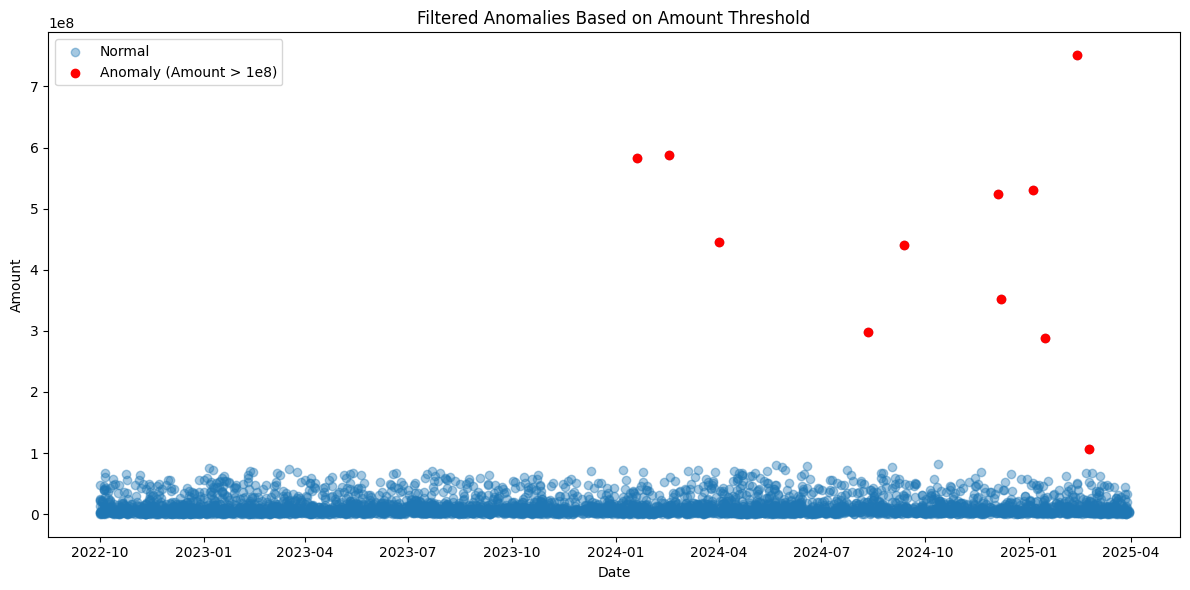

In [12]:
# Define threshold
amount_threshold = 1e8  # 100 million

# Only keep anomalies where amount > threshold
df['final_anomaly'] = (df['is_predicted_anomaly']) & (df['Amount'] > amount_threshold)

plt.figure(figsize=(12, 6))
plt.scatter(df['TransactionDate'], df['Amount'], label='Normal', alpha=0.4)
plt.scatter(df[df['final_anomaly']]['TransactionDate'], df[df['final_anomaly']]['Amount'], color='red', label='Anomaly (Amount > 1e8)')
plt.title('Filtered Anomalies Based on Amount Threshold')
plt.xlabel('Date')
plt.ylabel('Amount')
plt.legend()
plt.tight_layout()
plt.show()

## 6. .NET integration

In [14]:
joblib.dump(model, 'isoforest_model.pkl')

['isoforest_model.pkl']